# Introduction

The database used in this notebook is downloaded from kaggle:
https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european

It contains:
* +25,000 matches
* +10,000 players
* 11 European Countries with their lead championship
* Seasons 2008 to 2016
* Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
* Team line up with squad formation (X, Y coordinates)
* Betting odds from up to 10 providers
* Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches


Objectives for this notebook:
* to answer questions of interest
* to build models for predicting results and goals

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from typing import Tuple
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    PredictionErrorDisplay,
    ConfusionMatrixDisplay,
    classification_report,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (
    LogisticRegressionCV,
    LogisticRegression,
    SGDClassifier,
    LinearRegression,
)
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from yellowbrick.classifier import roc_auc
import math
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_rows", 200)

In [2]:
# Connecting to the database and creating cursor object
conn = sqlite3.connect("database.sqlite")
cursor = conn.cursor()

Displaying schema with the use of luna modeler 6.3.0
What teams improved the most/worst over these years (2008-2016)?
What team attributes led to the most victories?
Which leagues, teams scored the most?
Does different leagues has special team charcteristics?
Who are the best players in Europe over these years (2008-2016)
Relationship between players height and weight vs player attributes?

In [3]:
from IPython.display import IFrame, display

filepath = "SQLite.pdf"
IFrame(filepath, width=700, height=400)

# Cleaning data and initial analysis

## Player

The player table will be fetched, initially described and cleaned. Then stored in the new table in the database. 

Reading in the table.

In [4]:
player = pd.read_sql("""select * from player """, conn, parse_dates="birthday")
player.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146


Getting the year of birthday.

In [5]:
player["birthday"] = player["birthday"].dt.year

Converting player's weight to kg. 

In [6]:
player["weight"] = player["weight"] / 2.20462262

Checking for missing values.

In [7]:
player.isnull().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

Let's quickly check if we can remove player_fifa_api_id. That would be possible if there are no null values for player_api_id in player_attributes table. 

In [8]:
pd.read_sql(
    """select player_api_id from player_attributes where player_api_id is null""", conn
)

,player_api_id


Dropping player_fifa_api_id.

In [9]:
player.drop(["id", "player_fifa_api_id"], axis=1, inplace=True)

Although we expect that there may be some duplicates there won't be removed to prevent loosing data when joining. 

The duplicates will be remove only for the porpose of showing weight, height and birthday distribution. 

In [10]:
# Removing duplicates
player_without = player[~player[["player_name", "birthday"]].duplicated(keep=False)]

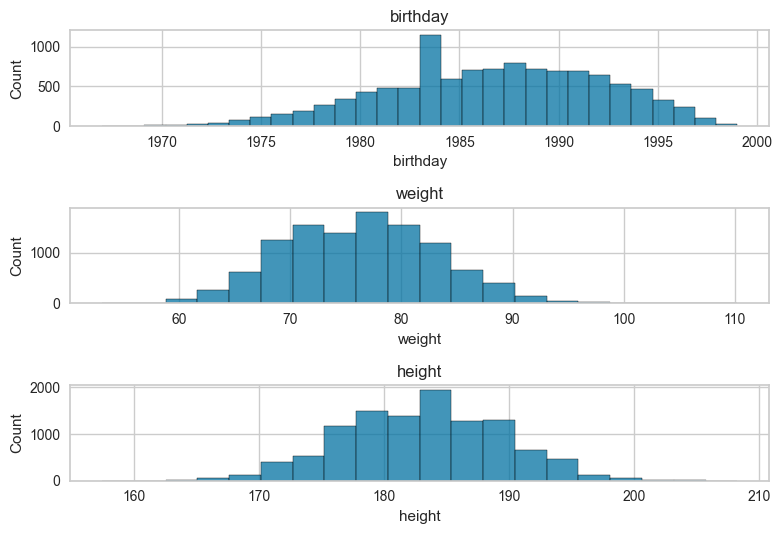

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
sns.histplot(player_without, x="birthday", bins=30, ax=ax1)
ax1.set(title="birthday")
sns.histplot(player_without, x="weight", bins=20, ax=ax2)
ax2.set(title="weight")
sns.histplot(player_without, x="height", bins=20, ax=ax3)
ax3.set(title="height")
plt.tight_layout()

In [12]:
df = player_without.reset_index()
def confidence_interval_mean(column: str, confidence: float) -> Tuple[float, float]:
    """Calculates confidence interval of mean value for the column."""

    # standard error
    SE = stats.sem(df[column])
    # t-value
    t_c = stats.t.ppf(confidence, df=len(df[column]) - 1)
    # lower and upper bound of confidence interval
    lb = df[column].mean() - t_c * SE
    ub = df[column].mean() + t_c * SE

    return round(lb, 2), round(ub, 2)

In [13]:
dictionary = defaultdict(list)
columns = ["birthday", "weight", "height"]
for column in columns:
    dictionary[column].append(confidence_interval_mean(column, 0.975))

pd.DataFrame(dictionary, index=["mean confidence interval"]).T

,mean confidence interval
birthday,"(1986.54, 1986.74)"
weight,"(76.25, 76.5)"
height,"(181.75, 181.99)"


The distribution of birthday is unimodal and the confidence interval for the mean value suggest lack of skewedness. There is one particular interesting year 1983 with over 1000 players born. The players are 180cm with 6cm standard deviations. They weight on average 76kg. We will be able to check if those numbers are differ signifficantly for particular teams.
Let's also check the dependencies of height and weight. 

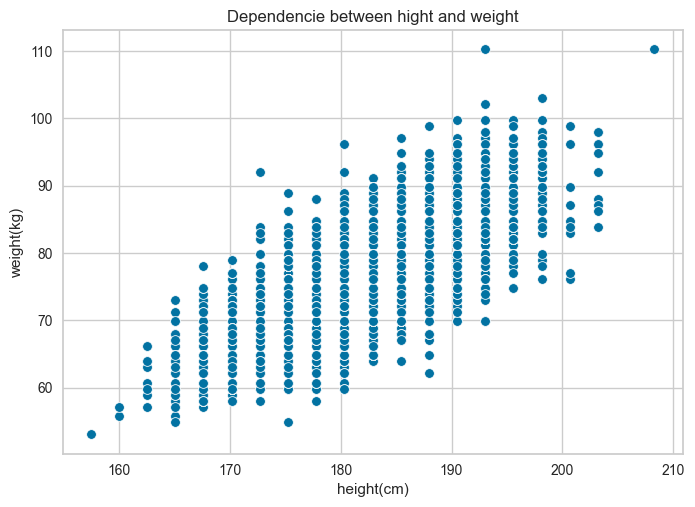

In [14]:
sns.scatterplot(data=player_without, x="height", y="weight")
plt.title("Dependencie between hight and weight")
plt.xlabel("height(cm)")
plt.ylabel("weight(kg)");

We can see a couple of outliers that shouldn't make much of a difference.

Now let's calculate BMI so we can use this as one of players attributes later on. 

BMI formula: 
BMI = Weight (kg) / Height (m) 2

In [15]:
player["BMI"] = player["weight"] / (player["height"] / 100) ** 2

In [16]:
player.head()

,player_api_id,player_name,birthday,height,weight,BMI
0,505942,Aaron Appindangoye,1992,182.88,84.82,25.36
1,155782,Aaron Cresswell,1989,170.18,66.22,22.87
2,162549,Aaron Doran,1991,170.18,73.94,25.53
3,30572,Aaron Galindo,1982,182.88,89.81,26.85
4,23780,Aaron Hughes,1979,182.88,69.85,20.89


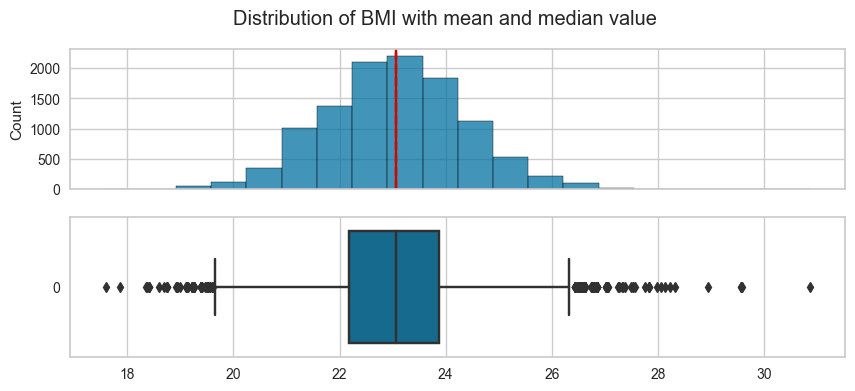

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))
sns.histplot(player["BMI"], bins=20, ax=ax1)
sns.boxplot(player["BMI"], orient="h", ax=ax2)
ax1.axvline(x=player["BMI"].mean(), color="r", linestyle="solid", label="BMI mean")
ax1.axvline(x=player["BMI"].median(), color="r", linestyle="dashed", label="BMI median")
plt.suptitle("Distribution of BMI with mean and median value");

In [18]:
player["BMI"].describe()[["mean", "50%"]]

mean   23.07
50%    23.06
Name: BMI, dtype: float64

Both values are very close which means the outliers don't have significant impact. Taking into account the classification of BMI: 
* Less than 18.5 Underweight 
* 18.5 to 24.9 Healthy weight 
* 25 to 29.9 Overweight but not obese 
* 30 to 34.9 Obese class I
Most of the players are having healthy weight. There are a few with too low BMI and some overweighted and one obese player. We need to remember that the BMI indicator is accurate for general population. Not the population of players. 

## Players attributes

The attributes were taken from FIFA video game. Those are the player skills ranked between 0 and 99. The mean of those skills is represented in overall_rating. 

Excellent 90-99
very good 80-89
good 70-79
just at 50-69
needs imporvement 40-49
insufficient 0-39

Let's see the player attributes table.

In [19]:
pd.set_option("display.max_columns", 100)
pl_att = pd.read_sql("""select * from player_attributes""", conn, parse_dates="date")
pl_att.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18,67.00,71.00,right,medium,medium,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00
1,2,218353,505942,2015-11-19,67.00,71.00,right,medium,medium,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00


Changing categories to numbers.

In [20]:
pl_att["attacking_work_rate"].value_counts().index

Index(['medium', 'high', 'low', 'None', 'norm', 'y', 'le', 'stoc'], dtype='object')

Replacing values of attacking_work_rate:

* medium, normal = 2
* low = 1
* high = 3
* None, y, stoc, le to np.nan

In [21]:
pl_att["attacking_work_rate"] = pl_att["attacking_work_rate"].replace(
    ["None", "y", "stoc", "le"], np.nan
)
pl_att["attacking_work_rate"] = pl_att["attacking_work_rate"].replace(
    {"medium": 2, "norm": 2, "low": 1, "high": 3}
)
pl_att["attacking_work_rate"].value_counts()

2.00    125418
3.00     42823
1.00      8569
Name: attacking_work_rate, dtype: int64

Engineering of defensive_work_rate column:

In [22]:
pl_att["defensive_work_rate"].value_counts().index

Index(['medium', 'high', 'low', '_0', 'o', '1', 'ormal', '2', '3', '5', '7',
       '0', '6', '9', '4', 'es', 'ean', 'tocky', '8'],
      dtype='object')

Replace the 'o' and 'es' values with null and backfill.

We have scale from 0 to 10 which will be splitted into 3 categories:
* 0-3 = 1
* 4-6 = 2
* 7-10 = 3

Then:
* low = 1
* medium = 2
* high = 3

Then:
* lean = 1
* ormal = 2
* tocky = 3

In [23]:
pl_att["defensive_work_rate"] = pl_att["defensive_work_rate"].replace(
    ["es", "o", "_0"], np.nan
)

In [24]:
dict_to_replace = {
    "0": 1,
    "1": 1,
    "2": 1,
    "3": 1,
    "low": 1,
    "ean": 1,
    "4": 2,
    "5": 2,
    "6": 2,
    "medium": 2,
    "ormal": 2,
    "7": 3,
    "8": 3,
    "9": 3,
    "tocky": 3,
    "high": 3,
}
pl_att["defensive_work_rate"] = pl_att["defensive_work_rate"].replace(dict_to_replace)

In [25]:
pl_att["defensive_work_rate"].value_counts()

2.00    131741
3.00     27577
1.00     19774
Name: defensive_work_rate, dtype: int64

Creating dummies for foot preferences.

In [26]:
pl_att.reset_index().head(1)

,index,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,0,1,218353,505942,2016-02-18,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00


In [27]:
pl_att = pd.concat([pl_att, pd.get_dummies(pl_att.preferred_foot, prefix="leg")], 1)

In [28]:
pl_att.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,1,218353,505942,2016-02-18,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00,0,1
1,2,218353,505942,2015-11-19,67.00,71.00,right,2.00,2.00,49.00,44.00,71.00,61.00,44.00,51.00,45.00,39.00,64.00,49.00,60.00,64.00,59.00,47.00,65.00,55.00,58.00,54.00,76.00,35.00,71.00,70.00,45.00,54.00,48.00,65.00,69.00,69.00,6.00,11.00,10.00,8.00,8.00,0,1


Dropping columns which won't be used.

In [29]:
pl_att.drop(["preferred_foot", "date"], axis=1, inplace=True)

Filling in the missing values.

In [30]:
pl_att = pl_att.sort_values(by=["potential", "player_api_id"]).fillna(method="ffill")

Testing for missing values.

In [31]:
pl_att.isnull().sum().sum()

0

Reducing the dataframe to mean values for players.

In [32]:
player_att = pl_att.groupby(["player_fifa_api_id", "player_api_id"]).mean()
player_att.reset_index().head(2)

,player_fifa_api_id,player_api_id,id,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,2,39357,64709.50,70.60,71.10,2.33,2.23,74.10,48.03,62.80,71.20,56.57,66.60,67.73,60.60,69.20,70.37,71.90,75.17,67.97,71.23,67.43,70.83,68.03,77.07,71.37,65.20,76.53,74.07,65.10,55.77,59.77,71.47,74.00,72.83,13.30,7.63,26.00,11.77,13.47,1.00,0.00
1,6,41762,6773.50,72.12,76.25,2.00,2.00,18.00,18.00,24.00,28.75,6.50,17.00,7.25,15.38,55.25,17.25,47.50,47.50,48.00,68.00,64.88,36.00,72.00,50.00,60.75,14.75,35.00,36.75,30.38,42.00,25.25,24.75,24.12,17.00,71.75,72.38,71.00,75.25,72.75,0.00,1.00


Now we need to make sure that columns for legs have either 1 or 0. The function will check if value is either highier or lower than 0.5.

In [33]:
def foot(row):
    """Returns updated value of row."""
    if row > 0.5:
        return 1
    else:
        return 0

Applying function.

In [34]:
player_att["leg_left"] = player_att["leg_left"].apply(foot)
player_att["leg_right"] = player_att["leg_right"].apply(foot)

We have a dataframe with all the attributes of the players. We can also add BMI and birthday to have full set of information. We will marge those datasets and then store as a new table.

In [35]:
player_att_clean = player.merge(player_att, on="player_api_id")
player_att_clean.drop(["height", "weight", "id"], axis=1, inplace=True)
player_att_clean.head(2)

,player_api_id,player_name,birthday,BMI,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,505942,Aaron Appindangoye,1992,25.36,63.60,67.60,2.00,2.00,48.60,43.60,70.60,60.60,43.60,50.60,44.60,38.60,63.60,48.60,60.00,64.00,59.00,46.60,65.00,54.60,58.00,54.00,76.00,34.60,65.80,52.20,44.60,53.60,47.60,63.80,66.00,67.80,5.60,10.60,9.60,7.60,7.60,0,1
1,155782,Aaron Cresswell,1989,22.87,66.97,74.48,2.21,2.00,70.79,49.45,52.94,62.27,29.15,61.09,61.88,62.12,63.24,61.79,76.00,74.94,75.24,67.85,84.73,65.91,75.30,72.88,51.76,54.12,65.06,57.88,51.48,57.45,53.12,69.39,68.79,71.52,12.18,8.67,14.24,10.36,12.91,1,0


In [36]:
## storing the table
# player_att_clean.to_sql('player_attributes_cleaned', conn)

## Country

In [37]:
country = pd.read_sql("""select * from country""", conn)
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


We have 11 countries to consider. 

## League

In [38]:
league = pd.read_sql("""select * from league""", conn)
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


**Which leagues are in which countries?

In [39]:
c_league = pd.read_sql(
    """select l.name league, c.name country 
                          from league l 
                          join country c 
                          on c.id=l.country_id """,
    conn,
)
c_league

,league,country
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


## Match

In [40]:
match = pd.read_sql("""select * from match""", conn, parse_dates="date")
match.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,...,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.20,3.50,1.80,3.30,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.30,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.20,3.50,1.90,3.20,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.30,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60


Assigning victory and punctation to see which teams got the highiest scores through the years.

In [41]:
def punctation_home(row):
    """Returns the number of points gained for home team."""
    pkt_diff = row["home_team_goal"] - row["away_team_goal"]

    if pkt_diff == 0:
        return 1
    elif pkt_diff > 0:
        return 3
    else:
        return 0

In [42]:
match["home_team_pkt"] = match.apply(punctation_home, axis=1)

In [43]:
def punctation_away(row):
    """Returns the number of points gained for away team."""
    pkt_diff = row["home_team_goal"] - row["away_team_goal"]

    # for draw
    if pkt_diff == 0:
        return 1
    # for won
    elif pkt_diff < 0:
        return 3
    # for loss
    else:
        return 0

In [44]:
match["away_team_pkt"] = match.apply(punctation_away, axis=1)

Adding column of home team results. 

In [45]:
def home_won(row):
    if row["home_team_pkt"] == 1:
        return "Draw"
    elif row["home_team_pkt"] == 0:
        return "Loss"
    else:
        return "Won"

In [46]:
match["home_result"] = match.apply(home_won, axis=1)

Removing columns with html values which doesn't add any value to machine learning as those values are known after the match.

In [47]:
columns_html = [
    "goal",
    "shoton",
    "shotoff",
    "foulcommit",
    "cross",
    "corner",
    "possession",
]

In [48]:
match.drop(columns_html, axis=1, inplace=True)

Season -> Start of season

Date -> Month

In [49]:
match["season_start"] = match["season"].apply(lambda x: int(x[:4]))

In [50]:
match["month"] = match["date"].dt.month

In [51]:
match.drop(["date", "season"], axis=1, inplace=True)

Cleaning the betting houses data. For the betting houses we see entries: B365H
B365D
B365A
BWH
BWD
BWA
IWH
IWD
IWA
LBH
LBD
LBA
PSH
PSD
PSA
WHH
WHD
WHA
SJH
SJD
SJA
VCH
VCD
VCA
GBH
GBD
GBA
BSH
BSD
BSA

All betting houses are betting on odds on home team, away team won or draw. We will produce new columns with average betts and later remove those columns. 

In [52]:
betting_houses = ["B365", "BW", "IW", "LB", "PS", "WH", "SJ", "VC", "GB", "BS"]

In [53]:
def average_odds(row, odds_for: str, betting_houses: str = betting_houses) -> float:
    """Calculates average odds from all betting companies for either home win, away win or draw.
    odds_for: A for Away Win, H for Home Win, D for Draw"""

    odds_count = 0
    odds_sum = 0
    for acronyme in betting_houses:
        column = acronyme + odds_for
        if pd.isna(row[column]) == False:
            odds_sum += row[column]
            odds_count += 1

    # Avoiding ZeroDevisionError
    if odds_count == 0:
        odds_count = 1

    return odds_sum / odds_count

In [54]:
match["odds_away"] = match.apply(lambda x: average_odds(x, "A"), axis=1)
match["odds_house"] = match.apply(lambda x: average_odds(x, "H"), axis=1)
match["odds_draw"] = match.apply(lambda x: average_odds(x, "D"), axis=1)

In [55]:
match["away"] = match["odds_away"] / (
    match["odds_away"] + match["odds_house"] + match["odds_draw"]
)
match["house"] = match["odds_house"] / (
    match["odds_away"] + match["odds_house"] + match["odds_draw"]
)
match["draw"] = match["odds_draw"] / (
    match["odds_away"] + match["odds_house"] + match["odds_draw"]
)

In [56]:
# Removing betting houses
betting_columns_remove = [
    house + bet for house in betting_houses for bet in ["A", "H", "D"]
]
match.drop(columns=betting_columns_remove, inplace=True)

In [57]:
# Removing the columns with coordinates of players position in formation.
position_columns = [
    ha + "_player_" + axis + str(number)
    for ha in ["away", "home"]
    for axis in ["X", "Y"]
    for number in range(1, 12)
]

match.drop(columns=position_columns, axis=1, inplace=True)

In [58]:
match.head(2)

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,card,home_team_pkt,away_team_pkt,home_result,season_start,month,odds_away,odds_house,odds_draw,away,house,draw
0,1,1,1,1,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1,1,Draw,2008,8,4.16,1.77,3.32,0.45,0.19,0.36
1,2,1,1,1,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1,1,Draw,2008,8,3.62,1.90,3.25,0.41,0.22,0.37


In [59]:
# match.drop(['league_id', 'id', 'country_id', 'match_api_id'], axis=1).to_sql('match_cleaned', conn)

## Plotting match attributes

**Who scores the highier numbre of goals- home or away team?**

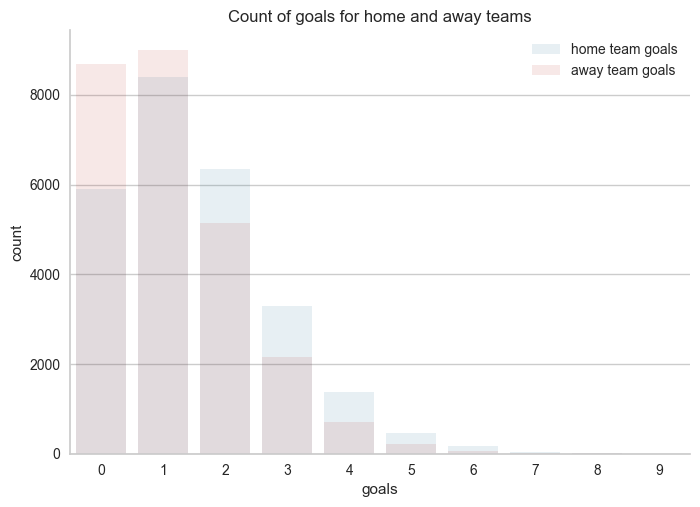

In [60]:
sns.countplot(
    x="home_team_goal", data=match, color="b", alpha=0.1, label="home team goals"
)
sns.countplot(
    x="away_team_goal", data=match, color="r", alpha=0.1, label="away team goals"
)
plt.legend()
plt.xlabel("goals")
plt.title("Count of goals for home and away teams")
sns.despine();

The count of goals for home and away is different. Away teams were more prone to get the lower number of goals than the home team. 

**What is the total number of matches played by season?**

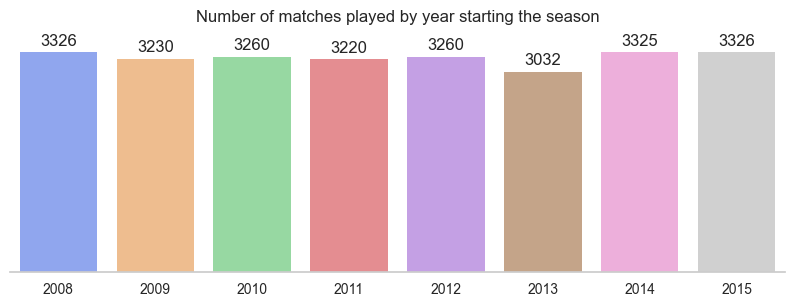

In [61]:
plt.figure(figsize=(10, 3))
ax = sns.countplot(data=match, x="season_start", palette="bright", alpha=0.5)
plt.title("Number of matches played by year starting the season", y=1.05)
sns.despine(left=True)
plt.yticks([])
plt.ylabel("")
plt.xlabel("")
plt.bar_label(ax.containers[0], padding=3);

In [62]:
match["season_start"].value_counts().describe()

count      8.00
mean    3247.38
std       97.21
min     3032.00
25%     3227.50
50%     3260.00
75%     3325.25
max     3326.00
Name: season_start, dtype: float64

Each season the number of matches in a dataset was between 3032 and 3326. With the highiest number of matches in 2014 and 2015. 

**What are the general statistics of matches per country?**

Marging country with matches.

In [63]:
matches = match[["country_id", "home_result"]].merge(
    country, left_on="country_id", right_on="id"
)

Displaying home results for each country. 

In [64]:
outcome_country = pd.crosstab(matches["name"], matches["home_result"])
outcome_country["sum"] = outcome_country.apply(lambda x: sum(x), axis=1)
outcome_country.sort_values(by="sum", ascending=False)

home_result,Draw,Loss,Won,sum
name,,,,
England,783,867,1390,3040
France,859,822,1359,3040
Spain,704,851,1485,3040
Italy,796,814,1407,3017
Germany,597,744,1107,2448
Netherlands,581,696,1171,2448
Portugal,533,611,908,2052
Poland,525,525,870,1920
Scotland,447,617,760,1824


Displaying outcome taking into account the number of matches. 

In [65]:
pd.crosstab(matches["name"], matches["home_result"]).apply(lambda x: x / sum(x), axis=1)

home_result,Draw,Loss,Won
name,,,
Belgium,0.25,0.29,0.47
England,0.26,0.29,0.46
France,0.28,0.27,0.45
Germany,0.24,0.30,0.45
Italy,0.26,0.27,0.47
Netherlands,0.24,0.28,0.48
Poland,0.27,0.27,0.45
Portugal,0.26,0.30,0.44
Scotland,0.25,0.34,0.42


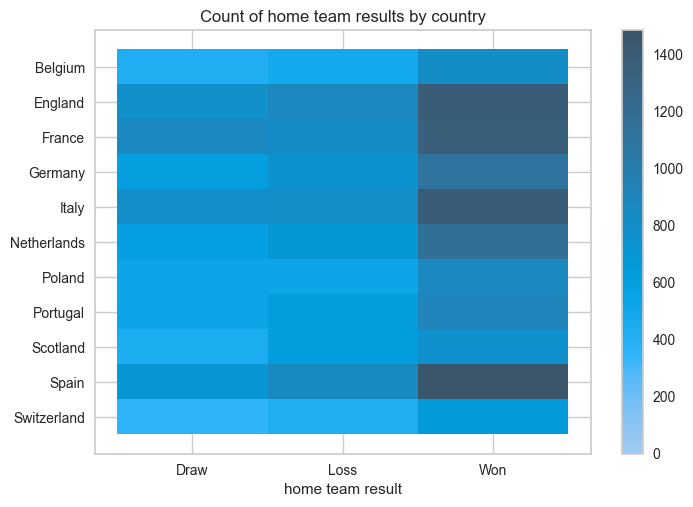

In [66]:
g = sns.histplot(y="name", x="home_result", data=matches, cbar=True)
plt.title("Count of home team results by country")
plt.ylabel("")
plt.xlabel("home team result");

## Team

In [67]:
team = pd.read_sql("""select * from team""", conn)

In [68]:
team.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.00,KRC Genk,GEN
1,2,9993,675.00,Beerschot AC,BAC


Let's check the overall information about the table.

In [69]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                296 non-null    int64  
 1   team_api_id       296 non-null    int64  
 2   team_fifa_api_id  285 non-null    float64
 3   team_long_name    296 non-null    object 
 4   team_short_name   296 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.7+ KB


We can see that there are 11 missing values in team_fifa_api_id. Most likely we won't need this column at all so leave it as it is at the moment. 
The duplicates were permanently removed with the following code:

```
team['team_long_name'].value_counts()
team[team['team_long_name'].isin(['Widzew Łódź', 'Royal Excel Mouscron', 'Polonia Bytom'])]

Removing values from dependent tables
cursor.execute('''update match set home_team_api_id=? where home_team_api_id=? or away_team_api_id=? ''', 
(9996, 274581, 274581))
cursor.execute('''update match set home_team_api_id=? where home_team_api_id=? or away_team_api_id=?''', 
(8031, 8020, 8020))
cursor.execute('''update match set home_team_api_id=? where home_team_api_id=? or away_team_api_id=?''', 
(8223, 8024, 8024))
cursor.execute('''update team_attributes set team_api_id=? where team_api_id=?''', (9996, 274581))
cursor.execute('''update team_attributes set team_api_id=? where team_api_id=?''', (8031, 8020))
cursor.execute('''update team_attributes set team_api_id=? where team_api_id=?''', (8223, 8024))
conn.commit()
```

In [70]:
# Quick check
pd.read_sql(
    """select home_team_api_id from match where home_team_api_id in (274581, 8020, 8024)""",
    conn,
)

,home_team_api_id


now we can remove those entries from our database

In [71]:
cursor.execute("""delete from team where id=? """, (2510,))
cursor.execute("""delete from team where id=? """, (31445,))
cursor.execute("""delete from team where id=? """, (32409,))
conn.commit()

In this table both team_fifa_api_id, id and team_short_name are insignificant so we can drop those columns

In [72]:
team.drop(columns=["id", "team_fifa_api_id"], axis=1, inplace=True)
team.head()

,team_api_id,team_long_name,team_short_name
0,9987,KRC Genk,GEN
1,9993,Beerschot AC,BAC
2,10000,SV Zulte-Waregem,ZUL
3,9994,Sporting Lokeren,LOK
4,9984,KSV Cercle Brugge,CEB


## Team attributes

In [73]:
team_att = pd.read_sql("""select * from team_attributes""", conn, parse_dates="date")

In [74]:
team_att.shape

(1458, 25)

In [75]:
team_att.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [76]:
team_att.drop(columns=["id", "team_fifa_api_id"], axis=1, inplace=True)

In [77]:
team_att["month"] = team_att["date"].dt.month
team_att["year"] = team_att["date"].dt.year
team_att[["year", "month"]].dtypes

year     int64
month    int64
dtype: object

In [78]:
def sezon_start(row):
    if row["month"] >= 8:
        return row["year"]
    else:
        return row["year"] - 1

In [79]:
team_att["sezon_start"] = team_att.apply(sezon_start, axis=1)

In [80]:
team_att[["month", "year", "date", "sezon_start"]].head(2)

,month,year,date,sezon_start
0,2,2010,2010-02-22,2009
1,9,2014,2014-09-19,2014


In [81]:
team_att.drop(columns=["month", "year", "date"], inplace=True)

In [82]:
team_att.shape

(1458, 23)

In [83]:
team_att.isnull().sum()

team_api_id                         0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
sezon_start                         0
dtype: int64

In [84]:
team_att.drop("buildUpPlayDribbling", axis=1, inplace=True)

In [85]:
team_att.dtypes

team_api_id                        int64
buildUpPlaySpeed                   int64
buildUpPlaySpeedClass             object
buildUpPlayDribblingClass         object
buildUpPlayPassing                 int64
buildUpPlayPassingClass           object
buildUpPlayPositioningClass       object
chanceCreationPassing              int64
chanceCreationPassingClass        object
chanceCreationCrossing             int64
chanceCreationCrossingClass       object
chanceCreationShooting             int64
chanceCreationShootingClass       object
chanceCreationPositioningClass    object
defencePressure                    int64
defencePressureClass              object
defenceAggression                  int64
defenceAggressionClass            object
defenceTeamWidth                   int64
defenceTeamWidthClass             object
defenceDefenderLineClass          object
sezon_start                        int64
dtype: object

Checking for categorical and numerical columns and printing unique values of categorical columns.

In [86]:
categorical_columns = []
numerical_columns = []
print("Unique values of categorical columns: ")
for column in team_att.columns:
    if team_att[column].dtype == "object":
        categorical_columns.append(column)
        print(team_att[column].unique())
    else:
        numerical_columns.append(column)

Unique values of categorical columns: 
['Balanced' 'Fast' 'Slow']
['Little' 'Normal' 'Lots']
['Mixed' 'Long' 'Short']
['Organised' 'Free Form']
['Normal' 'Risky' 'Safe']
['Normal' 'Lots' 'Little']
['Normal' 'Lots' 'Little']
['Organised' 'Free Form']
['Medium' 'Deep' 'High']
['Press' 'Double' 'Contain']
['Normal' 'Wide' 'Narrow']
['Cover' 'Offside Trap']


In [87]:
categorical = pd.get_dummies(team_att[categorical_columns]).reset_index()
categorical.head()

,index,buildUpPlaySpeedClass_Balanced,buildUpPlaySpeedClass_Fast,buildUpPlaySpeedClass_Slow,buildUpPlayDribblingClass_Little,buildUpPlayDribblingClass_Lots,buildUpPlayDribblingClass_Normal,buildUpPlayPassingClass_Long,buildUpPlayPassingClass_Mixed,buildUpPlayPassingClass_Short,buildUpPlayPositioningClass_Free Form,buildUpPlayPositioningClass_Organised,chanceCreationPassingClass_Normal,chanceCreationPassingClass_Risky,chanceCreationPassingClass_Safe,chanceCreationCrossingClass_Little,chanceCreationCrossingClass_Lots,chanceCreationCrossingClass_Normal,chanceCreationShootingClass_Little,chanceCreationShootingClass_Lots,chanceCreationShootingClass_Normal,chanceCreationPositioningClass_Free Form,chanceCreationPositioningClass_Organised,defencePressureClass_Deep,defencePressureClass_High,defencePressureClass_Medium,defenceAggressionClass_Contain,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Narrow,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Cover,defenceDefenderLineClass_Offside Trap
0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
1,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
2,2,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
3,3,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0
4,4,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0


In [88]:
numerical = team_att[numerical_columns].reset_index()
numerical.head()

,index,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,sezon_start
0,0,9930,60,50,60,65,55,50,55,45,2009
1,1,9930,52,56,54,63,64,47,44,54,2014
2,2,9930,47,54,54,63,64,47,44,54,2015
3,3,8485,70,70,70,70,70,60,70,70,2009
4,4,8485,47,52,53,48,52,47,47,52,2010


Creating a list of confidence interval for mean values of the features.

In [89]:
def confidence_interval_mean(column: str, confidence: float) -> Tuple[float, float]:
    """Calculates confidence interval of mean value for the column."""

    # standard error
    SE = stats.sem(numerical[column])
    # t-value
    t_c = stats.t.ppf(confidence, df=len(numerical[column]) - 1)
    # lower and upper bound of confidence interval
    lb = numerical[column].mean() - t_c * SE
    ub = numerical[column].mean() + t_c * SE

    return round(lb, 2), round(ub, 2)

In [90]:
print('Confidence intervals for mean values')
for column in numerical.columns[2:-1]:
    print(f'{column}: {(confidence_interval_mean(column, 0.95))}')

Confidence intervals for mean values
buildUpPlaySpeed: (51.96, 52.96)
buildUpPlayPassing: (48.02, 48.96)
chanceCreationPassing: (51.72, 52.61)
chanceCreationCrossing: (53.25, 54.21)
chanceCreationShooting: (53.52, 54.41)
defencePressure: (45.58, 46.46)
defenceAggression: (48.83, 49.67)
defenceTeamWidth: (51.77, 52.6)


The values are close to each other what could suggest that the distribution is normal.

Box plots for numerical features. We need to remove columns that won't interest us. 

In [91]:
# Create the figure and two subplots
for col in ["team_api_id", "sezon_start"]:
    numerical_columns.remove(col)

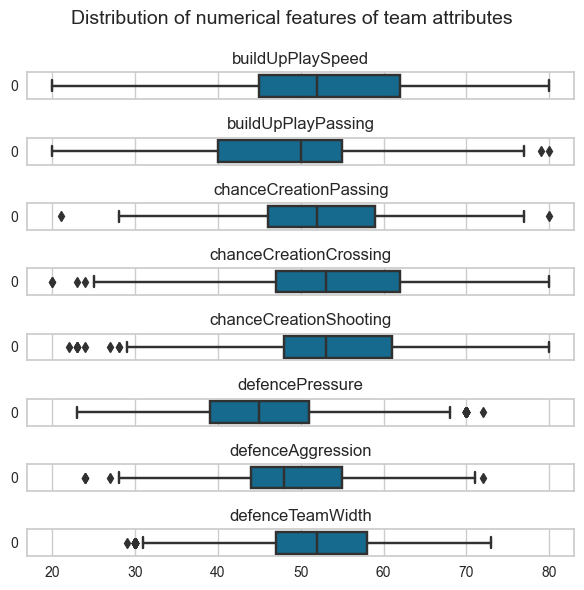

In [92]:
fig, axes = plt.subplots(nrows=len(numerical_columns), figsize=(6, 6), sharex=True)
fig.suptitle("Distribution of numerical features of team attributes", fontsize=14)

# Create the boxplot with Seaborn
for column, axis in zip(numerical_columns, axes):
    sns.boxplot(data=team_att[column], orient="h", ax=axis)
    axis.set_title(column)

# Show the plot
plt.tight_layout()
plt.show()

There are a couple of outliers but with the amount of data they have marginal impact on statistics.

Now let's merge the categorical and numerical data and store in new table. 

In [93]:
team_att = numerical.merge(categorical, on="index")
team_att.shape

(1458, 44)

Grouping on team and season start to calculate mean values. 

In [94]:
team_att = team_att.groupby(["team_api_id"]).mean().drop("index", axis=1)
team_att.head(2)

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,sezon_start,buildUpPlaySpeedClass_Balanced,buildUpPlaySpeedClass_Fast,buildUpPlaySpeedClass_Slow,buildUpPlayDribblingClass_Little,buildUpPlayDribblingClass_Lots,buildUpPlayDribblingClass_Normal,buildUpPlayPassingClass_Long,buildUpPlayPassingClass_Mixed,buildUpPlayPassingClass_Short,buildUpPlayPositioningClass_Free Form,buildUpPlayPositioningClass_Organised,chanceCreationPassingClass_Normal,chanceCreationPassingClass_Risky,chanceCreationPassingClass_Safe,chanceCreationCrossingClass_Little,chanceCreationCrossingClass_Lots,chanceCreationCrossingClass_Normal,chanceCreationShootingClass_Little,chanceCreationShootingClass_Lots,chanceCreationShootingClass_Normal,chanceCreationPositioningClass_Free Form,chanceCreationPositioningClass_Organised,defencePressureClass_Deep,defencePressureClass_High,defencePressureClass_Medium,defenceAggressionClass_Contain,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Narrow,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Cover,defenceDefenderLineClass_Offside Trap
team_api_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1601,47.33,46.17,55.50,60.33,53.50,47.17,47.33,49.33,2012.00,0.83,0.00,0.17,0.67,0.00,0.33,0.00,1.00,0.00,0.00,1.00,0.83,0.17,0.00,0.00,0.17,0.83,0.00,0.17,0.83,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
1773,52.00,50.00,50.00,53.00,54.00,43.00,44.00,50.00,2012.67,1.00,0.00,0.00,0.67,0.00,0.33,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00


In [95]:
team_att.reset_index(inplace=True)

In [96]:
team_att["key"] = team_att["team_api_id"].astype(str) + team_att["sezon_start"].astype(
    str
)

In [97]:
# team_att.to_sql('team_attributes_cleaned', conn)

# Questions

To check the most important information about this table we will need to join with two other tables and get the visual insight out of the data. 

In [98]:
joined = pd.read_sql(
    """select 
                               m.id, 
                               c.name country,
                               l.name league, 
                               m.season,
                               m.date, 
                               ht.team_long_name home_team,
                               at.team_long_name as away_team, 
                               m.home_team_goal,
                               m.away_team_goal, 
                               m.home_team_goal + m.away_team_goal total_goals,
                               case when home_team_goal > away_team_goal then 'win'
                                    when home_team_goal = away_team_goal then 'draw'
                                    else 'loss' 
                                    end home_team_result,
                               case when home_team_goal > away_team_goal then 3
                                    when home_team_goal = away_team_goal then 1
                                    else 0 end home_team_pkt,
                               case when home_team_goal > away_team_goal then 0
                                    when home_team_goal = away_team_goal then 1
                                    else 3 end away_team_pkt
                         from match m
                         join country c on m.country_id = c.id
                         join league l on m.league_id = l.id
                         join team ht on m.home_team_api_id = ht.team_api_id
                         join team at on m.away_team_api_id = at.team_api_id
                         order by date""",
    conn,
    parse_dates="date"
)
joined.head(2)

,id,country,league,season,date,home_team,away_team,home_team_goal,away_team_goal,total_goals,home_team_result,home_team_pkt,away_team_pkt
0,24559,Switzerland,Switzerland Super League,2008/2009,2008-07-18,BSC Young Boys,FC Basel,1,2,3,loss,0,3
1,24560,Switzerland,Switzerland Super League,2008/2009,2008-07-19,FC Aarau,FC Sion,3,1,4,win,3,0


## How many matches were played by each league through seasons?

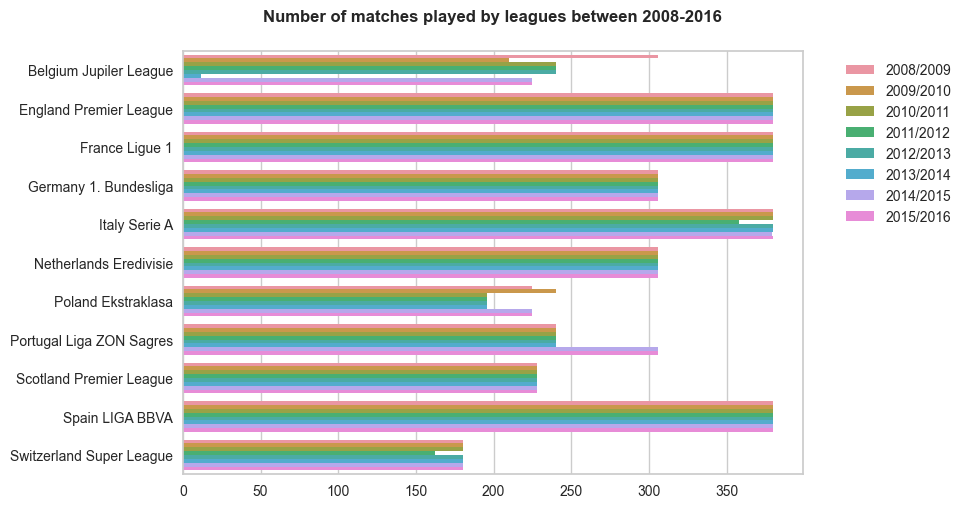

In [99]:
league_matches = joined.groupby(["league", "season"])["id"].count().reset_index()
sns.barplot(data=league_matches, y="league", x="id", hue="season")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title(
    "Number of matches played by leagues between 2008-2016", y=1.05, fontweight="bold"
)
plt.xlabel("")
plt.ylabel("");

England, France, Italy and Spain played more then 350 maches each season. Number of matches for Belgium varies greatly which may be a sign of incomplete data. Let's count for all seazons. 

## What are top home and away teams? - average number of goals per match

In [100]:
hteam_goals = (
    joined.groupby("home_team")["home_team_goal"]
    .apply(lambda x: round(sum(x) / len(x), 1))
    .reset_index()
    .sort_values(by="home_team_goal", ascending=False)
)

ateam_goals = (
    joined.groupby("away_team")["away_team_goal"]
    .apply(lambda x: round(sum(x) / len(x), 1))
    .reset_index()
    .sort_values(by="away_team_goal", ascending=False)
)
ateam_goals.head(2)

,away_team,away_team_goal
75,FC Barcelona,2.30
211,Real Madrid CF,2.20


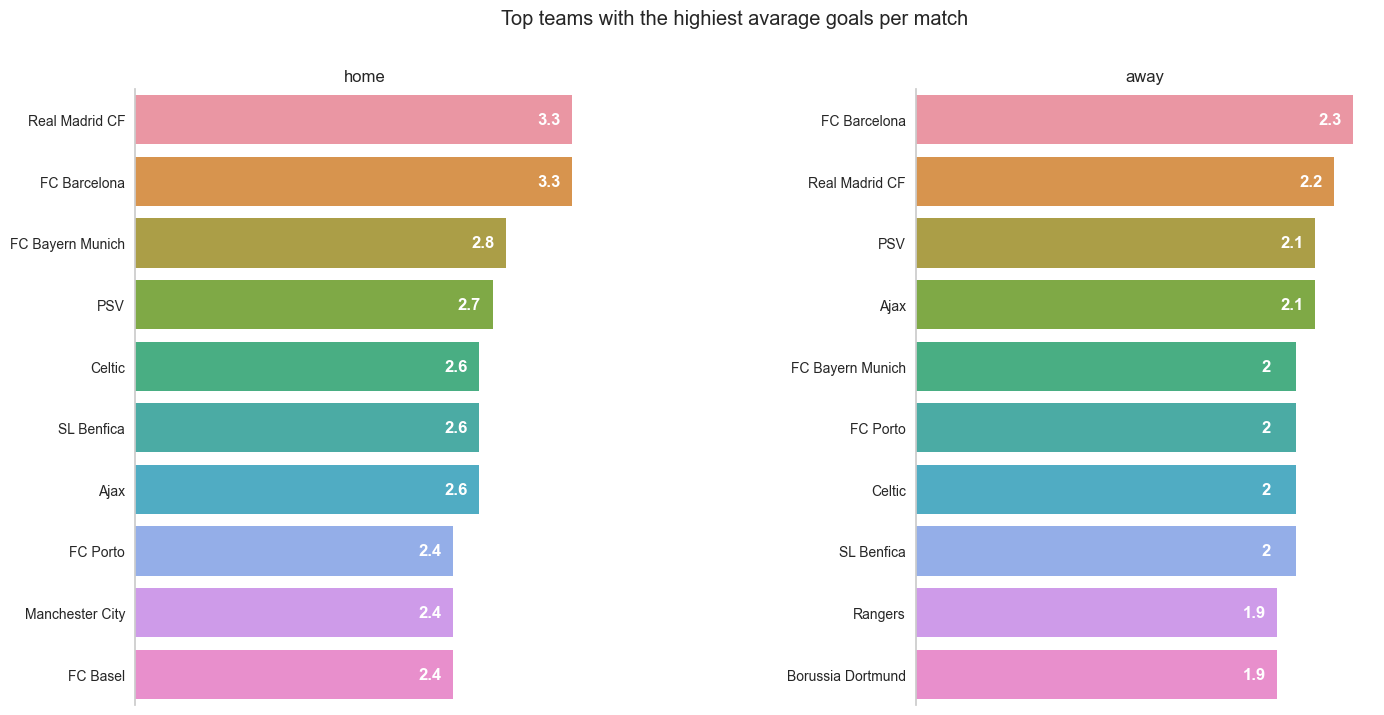

In [101]:
# create a figure
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Top teams with the highiest avarage goals per match")
# make two subplots side by side
plt.subplot(1, 2, 1)

# plotting top 10 home teams in the first side
ax = sns.barplot(data=hteam_goals[:10], x="home_team_goal", y="home_team")
plt.bar_label(ax.containers[0], padding=-25, color="w", fontweight="bold")
plt.ylabel("")
plt.title("home")
sns.despine(bottom=True)
plt.xlabel("")
plt.xticks([])

# plotting top 10 away teams in the second side
plt.subplot(1, 2, 2)
ax = sns.barplot(data=ateam_goals[:10], x="away_team_goal", y="away_team")
plt.bar_label(ax.containers[0], padding=-25, color="w", fontweight="bold")
plt.ylabel("")
plt.title("away")
sns.despine(bottom=True)
plt.xlabel("")
plt.xticks([])

plt.subplots_adjust(wspace=0.7)

The most popular teams on average score 3 goals per match at home. For away matches it is 2 goals which again adds to home advantage. It would be interesting to compare the tactics of Real Madrid and FC Barcelona. 

## Who scored the highiest number of goals each sezon away and at home?

In [102]:
hteam_goals_season = (
    joined.groupby(["season", "home_team"])["home_team_goal"].sum().reset_index()
)
hteam_goals_season = hteam_goals_season.loc[
    hteam_goals_season.groupby(["season"])["home_team_goal"].idxmax()
]

ateam_goals_season = (
    joined.groupby(["season", "away_team"])["away_team_goal"].sum().reset_index()
)
ateam_goals_season = ateam_goals_season.loc[
    ateam_goals_season.groupby(["season"])["away_team_goal"].idxmax()
]

pd.merge(hteam_goals_season, ateam_goals_season, on="season")

,season,home_team,home_team_goal,away_team,away_team_goal
0,2008/2009,FC Barcelona,61,FC Barcelona,44
1,2009/2010,Chelsea,68,Ajax,42
2,2010/2011,Real Madrid CF,61,FC Barcelona,49
3,2011/2012,FC Barcelona,73,Real Madrid CF,51
4,2012/2013,Real Madrid CF,67,FC Barcelona,52
5,2013/2014,FC Barcelona,64,Celtic,52
6,2014/2015,Real Madrid CF,65,Real Madrid CF,53
7,2015/2016,Real Madrid CF,70,PSV,47


We can see difference in max goals for home and away teams. Let's see if this difference is significant. For this purpose we will test the hypothesis. 

## Is there such a thing as home advantage?

Hypothesis: The average of goals for home and away team are equal. 

* $\alpha$ = 0.05
* $H_0$: $x1 = x2$
* $H_1$: $x1 > x2$

In [103]:
average_test = pd.read_sql(
    """select home_team_goal home,
                                     away_team_goal away
                              from match""",
    conn,
)

t, p = stats.ttest_ind(
    average_test["home"],
    average_test["away"],
    axis=0,
    equal_var=False,
    alternative="greater",
)
print("t-statistics: ", round(t, 2))
print("p-value: ", round(p, 2))

t-statistics:  35.78
p-value:  0.0


We reject the null hypothesis that the average of goals for home and away teams are equal. 
With 95% confidence, testing the same way we can not reject the alternative hypothesis that the mean of home team goals is highier than the mean of away team. 

## What are the total number of matches and goals for each league in the dataset?

In [104]:
compilation = (
    joined.groupby("league")
    .agg({"id": "count", "total_goals": "sum"})
    .rename(columns={"id": "total_matches"})
)
compilation["total_goals/total_matches"] = (
    compilation["total_goals"] / compilation["total_matches"]
)
compilation.sort_values(by="total_goals/total_matches", ascending=False)

,total_matches,total_goals,total_goals/total_matches
league,,,
Netherlands Eredivisie,2448,7542,3.08
Switzerland Super League,1422,4166,2.93
Germany 1. Bundesliga,2448,7103,2.90
Belgium Jupiler League,1698,4755,2.80
Spain LIGA BBVA,3040,8412,2.77
England Premier League,3040,8240,2.71
Scotland Premier League,1824,4804,2.63
Italy Serie A,3017,7895,2.62
Portugal Liga ZON Sagres,2052,5201,2.53


On average the total number of goals devided by total number of matches varies between 2.44 and 3.08. So we can expect to see cumulatively 2 to 3 goals per match.

## Which team won in each league each year?

In [105]:
joined.head(2)

,id,country,league,season,date,home_team,away_team,home_team_goal,away_team_goal,total_goals,home_team_result,home_team_pkt,away_team_pkt
0,24559,Switzerland,Switzerland Super League,2008/2009,2008-07-18,BSC Young Boys,FC Basel,1,2,3,loss,0,3
1,24560,Switzerland,Switzerland Super League,2008/2009,2008-07-19,FC Aarau,FC Sion,3,1,4,win,3,0


In [106]:
df1 = (
    joined[["league", "season", "home_team", "home_team_pkt"]]
    .rename(
        columns={
            "home_team": "team",
            "home_team_pkt": "team_pkt"
        }
    )
    .dropna()
)
df2 = (
    joined[["league", "season", "away_team", "away_team_pkt"]]
    .rename(
        columns={
            "away_team": "team",
            "away_team_pkt": "team_pkt"
        }
    )
    .dropna()
)
df1.shape, df2.shape

((25728, 4), (25728, 4))

In [107]:
frames = [df1, df2]
frames = pd.concat(frames)
frames.head(2)

,league,season,team,team_pkt
0,Switzerland Super League,2008/2009,BSC Young Boys,0
1,Switzerland Super League,2008/2009,FC Aarau,3


In [108]:
frames = frames.groupby(["league", "season", "team"])["team_pkt"].sum()
frames = frames.reset_index()

In [109]:
f = frames.groupby(["league", "season"])["team_pkt"].max().reset_index()

In [110]:
champions = f.merge(frames, on=["league", "season", "team_pkt"])

Check if the database is reilable with information from https://en.wikipedia.org/wiki/List_of_English_football_champions

In [111]:
champions.loc[champions.league == "England Premier League"]

,league,season,team_pkt,team
9,England Premier League,2008/2009,90,Manchester United
10,England Premier League,2009/2010,86,Chelsea
11,England Premier League,2010/2011,80,Manchester United
12,England Premier League,2011/2012,89,Manchester City
13,England Premier League,2011/2012,89,Manchester United
14,England Premier League,2012/2013,89,Manchester United
15,England Premier League,2013/2014,86,Manchester City
16,England Premier League,2014/2015,87,Chelsea
17,England Premier League,2015/2016,81,Leicester City


The outcome is the same as given by the source. Here are displayed teams that have won in season between 2008-2016.

In [112]:
champions

,league,season,team_pkt,team
0,Belgium Jupiler League,2008/2009,77,RSC Anderlecht
1,Belgium Jupiler League,2008/2009,77,Standard de Liège
2,Belgium Jupiler League,2009/2010,69,RSC Anderlecht
3,Belgium Jupiler League,2010/2011,65,RSC Anderlecht
4,Belgium Jupiler League,2011/2012,67,RSC Anderlecht
5,Belgium Jupiler League,2012/2013,67,RSC Anderlecht
6,Belgium Jupiler League,2013/2014,14,KV Oostende
7,Belgium Jupiler League,2014/2015,58,Club Brugge KV
8,Belgium Jupiler League,2015/2016,61,Club Brugge KV
9,England Premier League,2008/2009,90,Manchester United


## Which team won the championship the most times?

In [113]:
champions["team"].value_counts()[:10]

FC Basel               7
FC Barcelona           6
FC Bayern Munich       5
Celtic                 5
RSC Anderlecht         5
Juventus               5
Paris Saint-Germain    4
SL Benfica             4
FC Porto               4
Legia Warszawa         4
Name: team, dtype: int64

Taking into account the 8 seasons that the data was collected from, some of the teams won most of the times. The reason for this may be either lack of concurention or very high standard of football. 

## Which league score the most/fewest goals?

In [114]:
league_goals = pd.read_sql(
    """select distinct l.name, 
sum(m.home_team_goal + m.away_team_goal) over (partition by m.league_id) as goals
from match m
join league l 
on l.id=m.league_id
order by 2 desc""",
    conn,
)

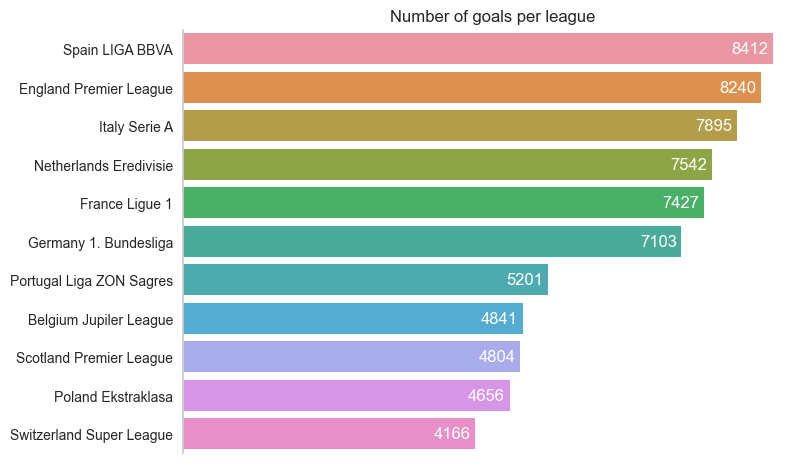

In [115]:
ax = sns.barplot(y=league_goals["name"], x=league_goals["goals"])
plt.bar_label(ax.containers[0], padding=-30, color="w")
plt.title("Number of goals per league")
sns.despine(bottom=True)
ax.set(xlabel="", xticks=[], ylabel="");

Those numbers should be compared with the number of teams taking place in the turnaments. Still Spain scores the highiest number of goals. 

## Who are the top players in each team and league?

In [116]:
players_team = pd.read_sql(
    """
select distinct t2.player_name, t2.overall_rating, t3.team_long_name, t3.league
from 
(select distinct p.player_api_id, m.home_team_api_id
from player p
join match m
on p.player_api_id=m.home_player_1 
or p.player_api_id= m.home_player_2
or p.player_api_id=m.home_player_3
or p.player_api_id=m.home_player_4
or p.player_api_id=m.home_player_5 
or p.player_api_id= m.home_player_6
or p.player_api_id=m.home_player_7
or p.player_api_id=m.home_player_8
or p.player_api_id= m.home_player_9
or p.player_api_id=m.home_player_10
or p.player_api_id=m.home_player_11) t1
left join
(select p.player_name, p.player_api_id, AVG(pa.overall_rating) overall_rating from player p
join player_attributes pa
on p.player_api_id=pa.player_api_id
group by 1, 2) t2
on t1.player_api_id=t2.player_api_id
join
(select t.team_long_name, l.name league, m.home_team_api_id
from team t
join match m
on m.home_team_api_id=t.team_api_id
join league l
on m.league_id=l.id) t3
on t1.home_team_api_id=t3.home_team_api_id
order by 2 desc""",
    conn,
)

In [117]:
# players_team.to_sql('players_team', conn)

In [118]:
pd.read_sql("""select * from players_team""", conn).head()

,index,player_name,overall_rating,team_long_name,league
0,0,Lionel Messi,92.19,FC Barcelona,Spain LIGA BBVA
1,1,Cristiano Ronaldo,91.28,Manchester United,England Premier League
2,2,Cristiano Ronaldo,91.28,Real Madrid CF,Spain LIGA BBVA
3,3,Franck Ribery,88.46,FC Bayern Munich,Germany 1. Bundesliga
4,4,Andres Iniesta,88.32,FC Barcelona,Spain LIGA BBVA


Let's take 2 best players from each league. 

In [119]:
pd.read_sql(
    """select * 
from
(select player_name, overall_rating, team_long_name, league, 
row_number() over (partition by league) rank
from players_team
)
where rank in (1, 2)""",
    conn,
)

,player_name,overall_rating,team_long_name,league,rank
0,Victor Valdes,83.64,Standard de Liège,Belgium Jupiler League,1
1,Mbark Boussoufa,79.69,RSC Anderlecht,Belgium Jupiler League,2
2,Cristiano Ronaldo,91.28,Manchester United,England Premier League,1
3,Wayne Rooney,87.22,Manchester United,England Premier League,2
4,Zlatan Ibrahimovic,88.29,Paris Saint-Germain,France Ligue 1,1
5,Karim Benzema,84.50,Olympique Lyonnais,France Ligue 1,2
6,Franck Ribery,88.46,FC Bayern Munich,Germany 1. Bundesliga,1
7,Arjen Robben,87.84,FC Bayern Munich,Germany 1. Bundesliga,2
8,Zlatan Ibrahimovic,88.29,Milan,Italy Serie A,1
9,Zlatan Ibrahimovic,88.29,Inter,Italy Serie A,2


## Can we predict how many goals each team will score in each match?

Let's see how accurate we may be about predicting how many goals scorred home team and away team. For this we will get the attributes of each team and predictions from betting houses.  

In [120]:
columns_from_match = [
    "home_team_api_id",
    "away_team_api_id",
    "home_team_goal",
    "away_team_goal",
    "season_start",
    "month",
    "odds_away",
    "odds_house",
    "odds_draw",
    "away",
    "house",
    "draw"
]

In [121]:
match = match[columns_from_match]
match["key"] = match["home_team_api_id"].astype(str) + match["season_start"].astype(str)

In [122]:
pd.read_sql("""select * from team_attributes_cleaned""", conn).columns

Index(['index', 'team_api_id', 'sezon_start', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression',
       'defenceTeamWidth', 'buildUpPlaySpeedClass_Balanced',
       'buildUpPlaySpeedClass_Fast', 'buildUpPlaySpeedClass_Slow',
       'buildUpPlayDribblingClass_Little', 'buildUpPlayDribblingClass_Lots',
       'buildUpPlayDribblingClass_Normal', 'buildUpPlayPassingClass_Long',
       'buildUpPlayPassingClass_Mixed', 'buildUpPlayPassingClass_Short',
       'buildUpPlayPositioningClass_Free Form',
       'buildUpPlayPositioningClass_Organised',
       'chanceCreationPassingClass_Normal', 'chanceCreationPassingClass_Risky',
       'chanceCreationPassingClass_Safe', 'chanceCreationCrossingClass_Little',
       'chanceCreationCrossingClass_Lots',
       'chanceCreationCrossingClass_Normal',
       'chanceCreationShootingClass_Little',
       'chanceCreationShootingClass_Lot

In [123]:
pd.read_sql("""select * from match_home where season_start=2008""", conn).head()

,index,home_team_api_id,away_team_api_id,home_team_goal,season_start,month,odds_away,odds_house,odds_draw,away,house,draw,key
0,0,9987,9993,1,2008,8,4.16,1.77,3.32,0.45,0.19,0.36,99872008
1,1,10000,9994,0,2008,8,3.62,1.90,3.25,0.41,0.22,0.37,100002008
2,2,9984,8635,0,2008,8,2.54,2.46,3.23,0.31,0.30,0.39,99842008
3,3,9991,9998,5,2008,8,6.53,1.44,3.81,0.55,0.12,0.32,99912008
4,4,7947,9985,1,2008,8,1.67,4.49,3.42,0.17,0.47,0.36,79472008


In [124]:
df = pd.read_sql(
    """select m.month, m.odds_away, m.odds_house, m.odds_draw, m.away, m.house, m.draw,
       t.buildUpPlaySpeed,
       t.buildUpPlayPassing, t.chanceCreationPassing, t.chanceCreationCrossing,
       t.chanceCreationShooting, t.defencePressure, t.defenceAggression,
       t.defenceTeamWidth, t.buildUpPlaySpeedClass_Balanced,
       t.buildUpPlaySpeedClass_Fast, t.buildUpPlaySpeedClass_Slow,
       t.buildUpPlayDribblingClass_Little, t.buildUpPlayDribblingClass_Lots,
       t.buildUpPlayDribblingClass_Normal, t.buildUpPlayPassingClass_Long,
       t.buildUpPlayPassingClass_Mixed, t.buildUpPlayPassingClass_Short,
       t.buildUpPlayPositioningClass_Organised,
       t.chanceCreationPassingClass_Normal, t.chanceCreationPassingClass_Risky,
       t.chanceCreationPassingClass_Safe, t.chanceCreationCrossingClass_Little,
       t.chanceCreationCrossingClass_Lots,
       t.chanceCreationCrossingClass_Normal,
       t.chanceCreationShootingClass_Little,
       t.chanceCreationShootingClass_Lots,
       t.chanceCreationShootingClass_Normal,
       t.chanceCreationPositioningClass_Organised, 
       t.defencePressureClass_Deep,
       t.defencePressureClass_High, 
       t.defencePressureClass_Medium,
       t.defenceAggressionClass_Contain, 
       t.defenceAggressionClass_Double,
       t.defenceAggressionClass_Press, t.defenceTeamWidthClass_Narrow,
       t.defenceTeamWidthClass_Normal, t.defenceTeamWidthClass_Wide,
       t.defenceDefenderLineClass_Cover,
       m.home_team_goal
       from match_home m
       join team_attributes_cleaned t
       on m.home_team_api_id=t.team_api_id
       where not odds_away= 0 and odds_away is not null and season_start=2013""",
    conn
)

Taking the names of columns from correlation matrix with correlations highier than 0.1 and lower than -0.1

In [125]:
corr = df.corr()["home_team_goal"].sort_values().reset_index()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(
    corr.style.background_gradient(cmap="coolwarm", axis=None, vmin=-1, vmax=1)
    .highlight_null(color="#f1f1f1")
    .format(precision=2)
)

,index,home_team_goal
0,nan,nan
1,odds_house,nan
2,draw,-0.20
3,buildUpPlayPositioningClass_Organised,-0.14
4,chanceCreationPositioningClass_Organised,-0.13
5,chanceCreationShootingClass_Normal,-0.10
6,buildUpPlayPassing,-0.10
7,buildUpPlayPassingClass_Long,-0.07
8,buildUpPlaySpeedClass_Balanced,-0.06
9,defencePressureClass_Deep,-0.04


In [126]:
corr.loc[corr.home_team_goal > 0.1]["index"].values, corr.loc[
    corr.home_team_goal < -0.1
]["index"].values

(array(['defencePressure', 'odds_draw', 'odds_away', 'away',
        'home_team_goal'], dtype=object),
 array(['draw', 'buildUpPlayPositioningClass_Organised',
        'chanceCreationPositioningClass_Organised'], dtype=object))

In [127]:
columns = [
    "house",
    "odds_house",
    "draw",
    "buildUpPlayPositioningClass_Organised",
    "chanceCreationPositioningClass_Organised",
    "chanceCreationShootingClass_Normal",
    "buildUpPlayPassing",
    "defencePressure",
    "odds_draw",
    "odds_away",
    "away",
]

Checking if the values are lineary correlated with number of goals. 

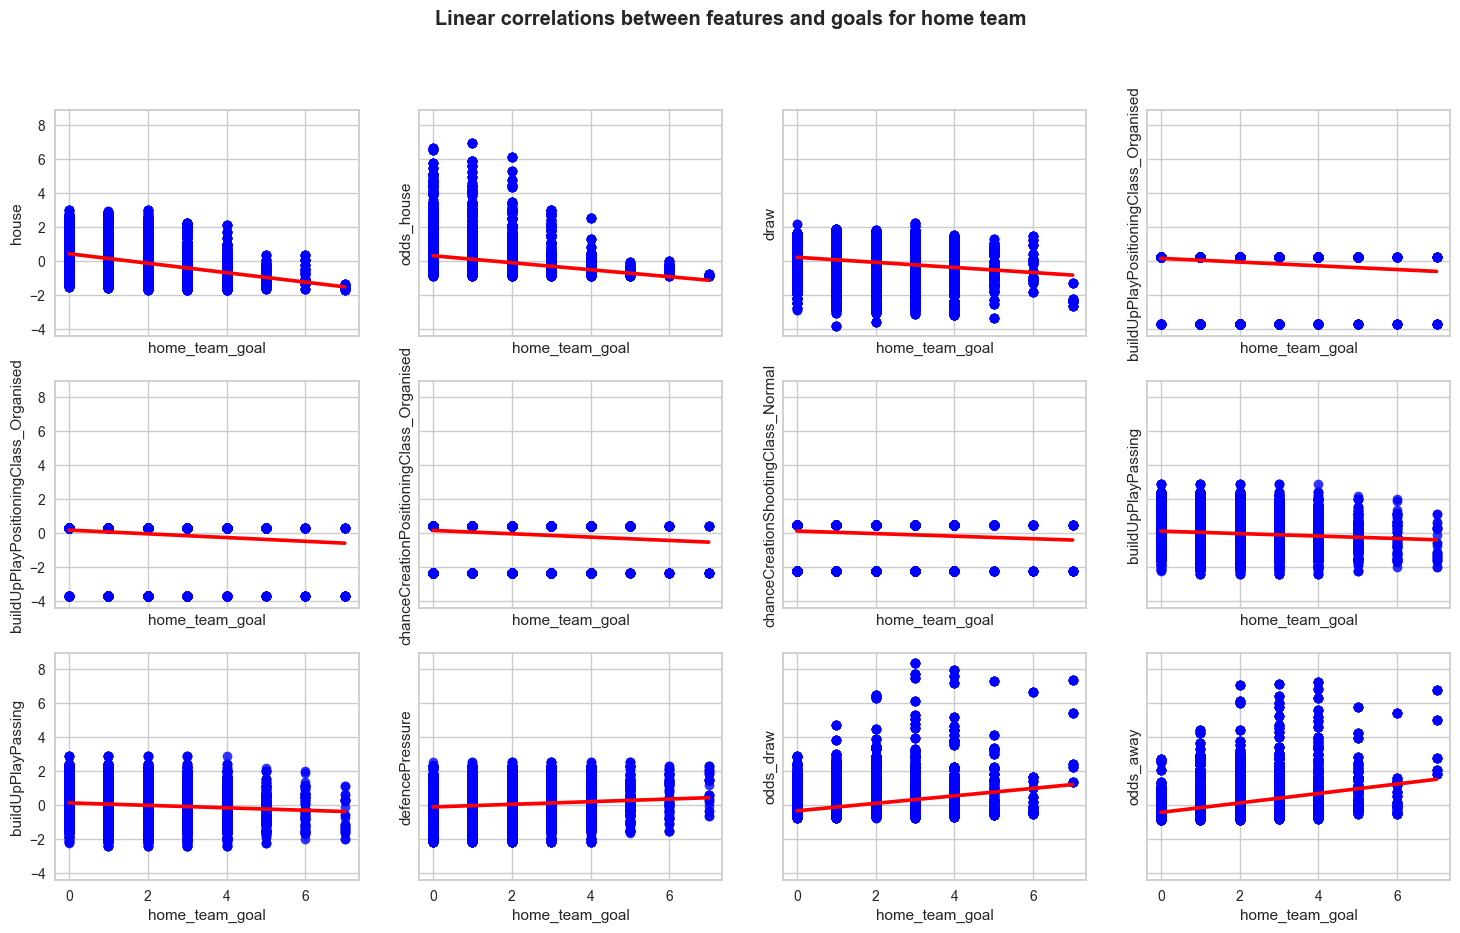

In [128]:
# Scaling data
X = StandardScaler().fit_transform(df[columns])
X = pd.DataFrame(X, columns=columns)
X["home_team_goal"] = df["home_team_goal"]

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(18, 10))
fig.suptitle(
    "Linear correlations between features and goals for home team", fontweight="bold"
)
for i in range(3):
    for j in range(4):
        col_name = columns[i * 3 + j]
        sns.regplot(
            x=df["home_team_goal"],
            y=X[col_name],
            ax=ax[i, j],
            scatter_kws={"color": "blue"},
            line_kws={"color": "red"},
        );

Still the number of goals could be predicted using bets. Characteristics of the team seems to have marginal effect on the home team goals. 

Looking at the graphs we can expect poor outcome of the model. Let's build and see how the model performed.

In [129]:
# Getting data of interest
X = df[columns]
y = np.array(df["home_team_goal"]).reshape(-1, 1)

X = StandardScaler().fit_transform(X)

# Initializing and fitting the model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("MAE: ", round(mean_absolute_error(y, y_pred), 2))
print("RMSE: ", round(math.sqrt(mean_absolute_error(y, y_pred)), 2))
print("R^2: ", round(model.score(X, y), 2))

MAE:  0.96
RMSE:  0.98
R^2:  0.17


The model metrics are very poor which means more likely that the features are not relevant enough.

Cross-validating and checking the residuals to confirm the assumptions. 

In [130]:
y_pred = cross_val_predict(model, X, y, cv=10)

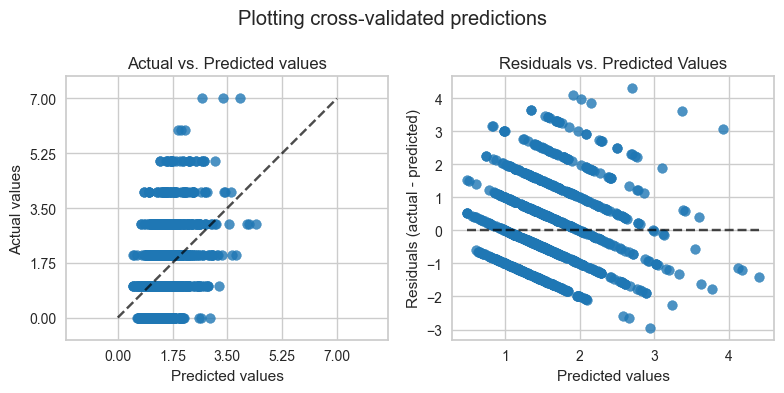

In [131]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

Actual values are usually highier than the predicted for lower number of goals. If the model is predicting highier scores there is a chance that it actually will be lower. The residual graph is not completly symetrical which means that the model is predicting with less than optimal metrics. 

## Are we able to predict the outcome of a match for home team?

In [132]:
# Columns od interest
match = pd.read_sql('''select* from match_cleaned''', conn)
to_pred = match[
    ["odds_away", "odds_house", "odds_draw", "away", "house", "draw", "home_result"]
]
to_pred.head(2)

,odds_away,odds_house,odds_draw,away,house,draw,home_result
0,4.16,1.77,3.32,0.45,0.19,0.36,Draw
1,3.62,1.90,3.25,0.41,0.22,0.37,Draw


In [133]:
# Getting data
to_pred.dropna(inplace=True)
X = to_pred.drop("home_result", axis=1)
y = to_pred["home_result"]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

models = [
    LogisticRegression(solver="lbfgs", max_iter=10000),
    SVC(gamma="auto"),
    NuSVC(gamma="auto"),
    LinearSVC(dual=False, max_iter=10000),
    SGDClassifier(max_iter=10000, tol=1e-3),
    KNeighborsClassifier(),
    LogisticRegressionCV(cv=3, max_iter=10000),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300),
]
model_name = [
    "LogisticRegression",
    "SVC",
    "NuSVC",
    "LinearSVC",
    "SGDClassifier",
    "KNeighborsClassifier",
    "LogisticRegressionCV",
    "BaggingClassifier",
    "ExtraTreesClassifier",
    "RandomForestClassifier",
]
for model, name in zip(models, model_name):
    print(f"{name}: {round(model.fit(X_train, y_train).score(X_test, y_test), 2)}")

LogisticRegression: 0.54
SVC: 0.54
NuSVC: 0.35
LinearSVC: 0.54
SGDClassifier: 0.54
KNeighborsClassifier: 0.45
LogisticRegressionCV: 0.54
BaggingClassifier: 0.45
ExtraTreesClassifier: 0.46
RandomForestClassifier: 0.48


Logistic regression gave the highiest accuracy score which still is unsatisfactory. Let's check other metrics. 

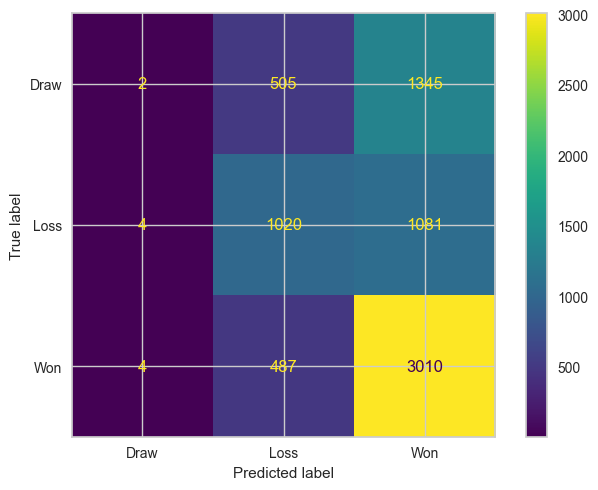

In [134]:
# Checking the confussion matrix for logistic regression
logistic = LogisticRegression().fit(X_train, y_train)
y_pred = logistic.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [135]:
# Creating classification reports
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Draw       0.20      0.00      0.00      1852
        Loss       0.51      0.48      0.50      2105
         Won       0.55      0.86      0.67      3501

    accuracy                           0.54      7458
   macro avg       0.42      0.45      0.39      7458
weighted avg       0.45      0.54      0.46      7458



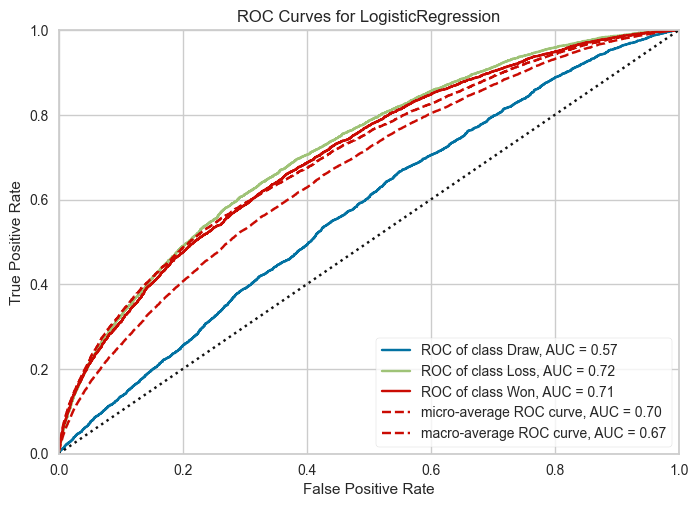

ROCAUC(ax=<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=LogisticRegression())

In [136]:
# Checking the roc curves
roc_auc(logistic, X_train, y_train)

The model predicts comperably bad loses and wins, draws are even worse. Metrics are very low.

# Data Studio Code 

Exploration of players attributes taking into account its team.

In [137]:
players_2016 = pd.read_sql(
    """
select distinct t2.player_name, t1.player_api_id, t2.overall_rating, t3.team_long_name, t3.league
from 
(select distinct p.player_api_id, m.home_team_api_id
from player p
join match m
on p.player_api_id=m.home_player_1 
or p.player_api_id= m.home_player_2
or p.player_api_id=m.home_player_3
or p.player_api_id=m.home_player_4
or p.player_api_id=m.home_player_5 
or p.player_api_id= m.home_player_6
or p.player_api_id=m.home_player_7
or p.player_api_id=m.home_player_8
or p.player_api_id= m.home_player_9
or p.player_api_id=m.home_player_10
or p.player_api_id=m.home_player_11
where m.season='2015/2016') t1
left join
(select p.player_name, p.player_api_id, AVG(pa.overall_rating) overall_rating from player p
join player_attributes pa
on p.player_api_id=pa.player_api_id
group by 1, 2) t2
on t1.player_api_id=t2.player_api_id
join
(select t.team_long_name, l.name league, m.home_team_api_id
from team t
join match m
on m.home_team_api_id=t.team_api_id
join league l
on m.league_id=l.id) t3
on t1.home_team_api_id=t3.home_team_api_id
order by 2 desc""",
    conn,
)

In [138]:
players_2016.head()

,player_name,player_api_id,overall_rating,team_long_name,league
0,Alexandre Azevedo,750584,58.00,FC Arouca,Portugal Liga ZON Sagres
1,Fynn Arkenberg,748432,58.00,Hannover 96,Germany 1. Bundesliga
2,Greg Taylor,744907,51.91,Kilmarnock,Scotland Premier League
3,Tom Davies,742405,51.00,Everton,England Premier League
4,Linus Obexer,733787,51.00,BSC Young Boys,Switzerland Super League


In [139]:
players = pd.read_sql("""select * from player_attributes_cleaned""", conn)

In [140]:
players_2016 = pd.merge(
    players_2016, players, on=["player_name", "player_api_id", "overall_rating"]
).drop("index", axis=1)

In [141]:
players_2016.head(2)

,player_name,player_api_id,overall_rating,team_long_name,league,birthday,BMI,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,leg_left,leg_right
0,Alexandre Azevedo,750584,58.00,FC Arouca,Portugal Liga ZON Sagres,1997,22.15,66.00,2.00,2.00,47.00,39.00,53.00,60.00,37.00,54.00,40.00,45.00,55.00,56.00,63.00,60.00,51.00,54.00,76.00,59.00,58.00,55.00,57.00,38.00,62.00,56.00,41.00,47.00,52.00,56.00,66.00,62.00,8.00,9.00,13.00,11.00,13.00,0,1
1,Fynn Arkenberg,748432,58.00,Hannover 96,Germany 1. Bundesliga,1996,22.60,68.00,2.00,2.00,48.00,26.00,57.00,49.00,24.00,41.00,39.00,20.00,41.00,42.00,64.00,68.00,50.00,48.00,52.00,46.00,68.00,50.00,67.00,25.00,52.00,55.00,38.00,36.00,45.00,63.00,69.00,68.00,8.00,8.00,12.00,12.00,6.00,0,1


In [142]:
players_2016.to_csv("players_2016")

https://lookerstudio.google.com/reporting/0ae2b3f3-28f9-455d-9f69-5290515b4417

# Conclusions

Both predictions for the number of goals and the result of match can be evaluated on odds from betting houses with very low metrics. 

Seems that matches outcomes are hard to predict with machine learning algorithms. 

Most team attributes have very weak correlations with number of goals or match result. 

We can extract some interesting facts about the leagues and teams from the dataset.

Home advantage is significant. 

# Imporovements

Extracting more features to check for linear and logistic model assumptions. 

Performing features engineering.

Scrapping data from sources with other features. 